<a href="https://colab.research.google.com/github/antoinexp/markov-chains-COM-516/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is provided as a starting point to help you generate random instances G1 and G2 as mentioned in the handout.

You are free to use and modify it at your own convenience.

---



In [1]:
import scipy.stats as st
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2
from time import time
import pandas as pd

In [2]:
class DatasetGenerator(object):
    def __init__(self, N=100):
        self.N = N
        self.x = None
        self.v = None
        self.refresh()

    def refresh(self):
        raise Exception("undefined")

In [3]:
class G1(DatasetGenerator):
    def refresh(self):
        self.x = st.uniform().rvs((self.N,2))
        self.v = st.uniform().rvs((self.N,))

In [4]:
class G2(DatasetGenerator):
    def refresh(self):
        self.x = st.uniform().rvs((self.N,2))
        self.v = np.exp(st.norm(-0.85, 1.3).rvs((self.N,)))

### Uniform distribution ($\mathcal U([0,1])$)

In [5]:
g1 = G1(100)

Examples:

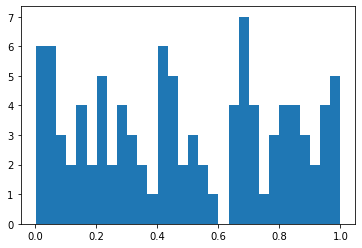

numpy.ndarray

In [6]:
# Plot a histogram of the v array
plt.hist(g1.v, bins=30)
plt.show()
type(g1.v)

/home/spaghet/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


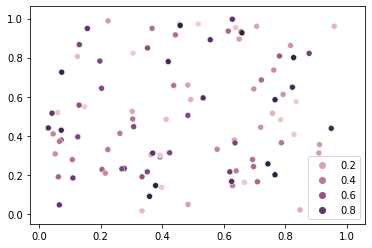

In [7]:
# plot the position of the points
# plt.figure(figsize=(5,5))
sns.scatterplot(g1.x[:,0], g1.x[:,1], hue=g1.v)
plt.show()

You can refresh the dataset

In [8]:
g1.refresh() # generate a new dataset

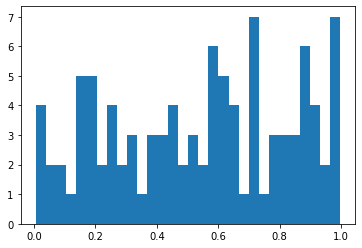

In [9]:
plt.hist(g1.v, bins=30)
plt.show()

Or for instance, you can generate 10 instances and compute the average position of all the points:

In [10]:
m = np.array([0., 0.])

for _ in range(10):
  g1.refresh() # refresh the dataset
  m  += 0.1*g1.x.mean()

print(m)

[0.50680201 0.50680201]


### Test on log-normal distribution

In [11]:
g2 = G2()

Example:

you can use g2 to generate an instance of the lognormal distribution

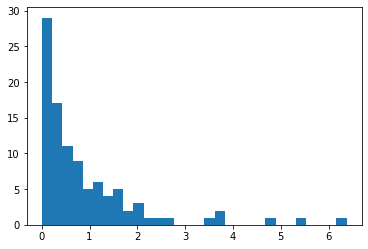

In [12]:
plt.hist(g2.v, bins=30)
plt.show()

/home/spaghet/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


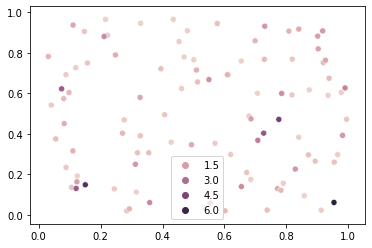

In [13]:
# plot the position of the points
# plt.figure(figsize=(5,5))
sns.scatterplot(g2.x[:,0], g2.x[:,1], hue=g2.v)
plt.show()

In [14]:
g2.refresh() # to generate a new x and v

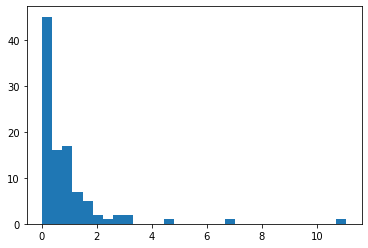

In [15]:
plt.hist(g2.v, bins=30)
plt.show()

---

### Metropolis Hastings

In [16]:
# fill-in this section with your code

from SimulatedAnnealingtris import SimulatedAnnealing as Sim_an3
from SimulatedAnnealing import SimulatedAnnealing as Sim_an1
from SimulatedAnnealingbis import SimulatedAnnealing as Sim_an2

In [17]:

lambda_ = 1
dataset = g1
print(g1.x.shape)

(100, 2)


In [18]:
def create_data_model(dataset):
    """Stores the data for the problem."""
    cities = dataset.x
    dist =  np.zeros((dataset.N, dataset.N))
    radius = np.inf
    center = None
    min_dist = np.inf
    min_i = None
    min_j = None
    max_dist = 0
    max_i = None
    max_j = None
    for i in range(dataset.N):
      r = np.linalg.norm(cities[i] - [0.5, 0.5])  # or most populous
      if r < radius:
        radius = r
        center = i
      for j in range(dataset.N):
        dist[i, j] = np.linalg.norm(cities[i] - cities[j])
        if dist[i, j] < min_dist and dist[i, j] != 0:
          min_dist = dist[i, j]
          min_i = i
          min_j = j
        if dist[i, j] > max_dist:
          max_dist = dist[i, j]
          max_i = i
          max_j = j
    print(cities[center])

    data = {}
    data['distance_matrix'] = np.round(dist / min_dist)
    data['num_vehicles'] = 1
    data['depot'] = center
    data['min_dist'] = min_dist
    data['min_i'] = min_i
    data['min_j'] = min_j
    data['max_dist'] = max_dist
    data['max_i'] = max_i
    data['max_j'] = max_j
    return data

def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

def get_routes(solution, routing, manager):
  """Get vehicle routes from a solution and store them in an array."""
  # Get vehicle routes and store them in a two dimensional array whose
  # i,j entry is the jth location visited by vehicle i along its route.
  routes = []
  for route_nbr in range(routing.vehicles()):
    index = routing.Start(route_nbr)
    route = [manager.IndexToNode(index)]
    while not routing.IsEnd(index):
      index = solution.Value(routing.NextVar(index))
      route.append(manager.IndexToNode(index))
    routes.append(route)
  return routes

def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print('Objective: {}'.format(solution.ObjectiveValue() * data['min_dist']))
    index = routing.Start(0)
    plan_output = 'Route for vehicle 0:\n'
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
    print(plan_output)
    plan_output += 'Route distance: {}miles\n'.format(route_distance)

# Instantiate the data problem.
data = create_data_model(dataset)

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], [data['min_i']], [data['min_j']])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC


[0.54249863 0.49578969]


In [21]:
iterations = 500
cycles = 5
runs = 3
alpha = 0.75
lmbds = 10

100%|██████████| 500/500 [00:00<00:00, 934.45it/s]


Beta : 0.026260 
Beta : 0.035013 
Beta : 0.046685 
Beta : 0.062246 
Beta : 0.082995 
[0.52498912 0.43806879]
Beta : 0.000000 
Beta : 0.016255 
Beta : 0.028563 
Beta : 0.040407 
Beta : 0.070926 
[0.52498912 0.43806879]
Beta : 0.136874 
Beta : 0.182499 
Beta : 0.243332 
Beta : 0.324442 
Beta : 0.432589 
[0.52498912 0.43806879]
Beta : 0.412872 
Beta : 0.550496 
Beta : 0.733994 
Beta : 0.978659 
Beta : 1.304879 
[0.52498912 0.43806879]
Beta : 0.136564 
Beta : 0.182086 
Beta : 0.242781 
Beta : 0.323708 
Beta : 0.431610 
[0.52498912 0.43806879]
Beta : 0.066077 
Beta : 0.088103 
Beta : 0.117471 
Beta : 0.156628 
Beta : 0.240596 
[0.52498912 0.43806879]
Beta : 0.020023 
Beta : 0.036755 
Beta : 0.051921 
Beta : 0.100286 
Beta : 0.150192 
[0.52498912 0.43806879]
Beta : 0.025061 
Beta : 0.033414 
Beta : 0.047232 
Beta : 0.074163 
Beta : 0.133483 
[0.52498912 0.43806879]
Beta : 0.017224 
Beta : 0.022966 
Beta : 0.042785 
Beta : 0.057047 
Beta : 0.077251 
[0.52498912 0.43806879]
Beta : 0.013556 
Be

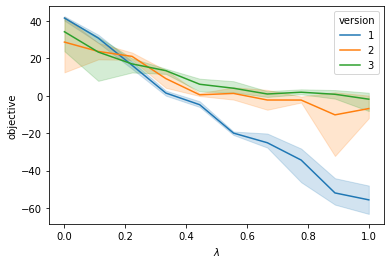

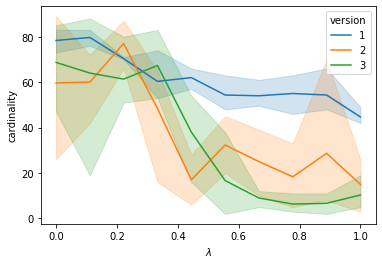

In [22]:



lambdas = np.linspace(0, 1, lmbds)
results = pd.DataFrame(columns=['run', '$\lambda$', 'version', 'objective', 'cardinality'])
start_time = time()
for i in range(runs):
    g1.refresh()
    dataset = g1

    for lmbd in lambdas:

        # -------------------------------------------------- Sim_an1 --------------------------------------------------
        SA = Sim_an1(lmbd, dataset)
        SA.heat_cool_cycles(iterations, cycles)
        results = results.append({'run': i, '$\lambda$': lmbd, 'version': '1', 'objective': SA.S.get_objective(), 'cardinality': SA.S.assignments.sum()}, ignore_index = True)

        # -------------------------------------------------- Sim_an2 --------------------------------------------------
        SA = Sim_an2(lmbd, dataset,alpha =alpha)
        SA.heat_cool_cycles(iterations, cycles)
        results = results.append({'run': i, '$\lambda$': lmbd, 'version': '2', 'objective': SA.S.get_objective(), 'cardinality': SA.S._assignments.sum()}, ignore_index = True)

        # -------------------------------------------------- Sim_an3 --------------------------------------------------
        # Instantiate the data problem.
        data = create_data_model(dataset)

        # Create the routing index manager.
        manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], [data['min_i']], [data['min_j']])

        # Create Routing Model.
        routing = pywrapcp.RoutingModel(manager)

        transit_callback_index = routing.RegisterTransitCallback(distance_callback)

        # Define cost of each arc.
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        # Setting first solution heuristic.
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

        # Solve the problem.
        solution = routing.SolveWithParameters(search_parameters)

        SA = Sim_an3(lmbd, dataset,alpha=alpha,order = get_routes(solution, routing, manager)[0])
        SA.heat_cool_cycles(iterations, cycles)
        results = results.append({'run': i, '$\lambda$': lmbd, 'version': '3', 'objective': SA.S.get_objective(), 'cardinality': SA.S._assignments.sum()}, ignore_index = True)
end_time = time()
print(end_time - start_time)
results['cardinality'] = results['cardinality'].astype(int)
sns.lineplot(data = results, x = '$\lambda$', y = 'objective', hue ='version')
plt.savefig("plot_cg1.png")
plt.show()
sns.lineplot(data = results, x = '$\lambda$', y = 'cardinality', hue = 'version')
plt.savefig("plot_eg1.png")
plt.show()



100%|██████████| 500/500 [00:00<00:00, 911.14it/s] 


Beta : 0.006600 
Beta : 0.013200 
Beta : 0.026399 
Beta : 0.052798 
Beta : 0.105597 
[0.49002722 0.52844635]
Beta : 0.108105 
Beta : 0.216211 
Beta : 0.432421 
Beta : 0.864842 
Beta : 1.729684 
[0.49002722 0.52844635]
Beta : 0.102250 
Beta : 0.204501 
Beta : 0.409001 
Beta : 0.818003 
Beta : 1.636006 
[0.49002722 0.52844635]
Beta : 0.023559 
Beta : 0.047119 
Beta : 0.094237 
Beta : 0.188475 
Beta : 0.376949 
[0.49002722 0.52844635]
Beta : 0.042781 
Beta : 0.085562 
Beta : 0.171124 
Beta : 0.342248 
Beta : 0.684495 
[0.49002722 0.52844635]
Beta : 0.020014 
Beta : 0.040028 
Beta : 0.080056 
Beta : 0.160111 
Beta : 0.320222 
[0.49002722 0.52844635]
Beta : 0.022278 
Beta : 0.044557 
Beta : 0.089113 
Beta : 0.178226 
Beta : 0.356452 
[0.49002722 0.52844635]
Beta : 0.009760 
Beta : 0.019520 
Beta : 0.039039 
Beta : 0.078079 
Beta : 0.156158 
[0.49002722 0.52844635]
Beta : 0.013782 
Beta : 0.027565 
Beta : 0.055129 
Beta : 0.110258 
Beta : 0.220517 
[0.49002722 0.52844635]
Beta : 0.011348 
Be

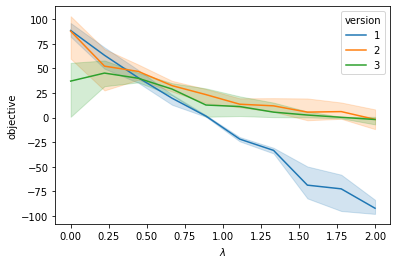

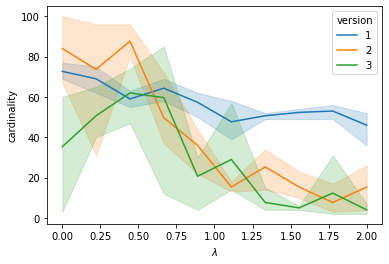

In [20]:
lambdas = np.linspace(0, 2, lmbds)
results = pd.DataFrame(columns=['run', '$\lambda$', 'version', 'objective', 'cardinality'])
for i in range(runs):
    g2.refresh()
    dataset = g2
    for lmbd in lambdas:
        # -------------------------------------------------- Sim_an1 --------------------------------------------------
        SA = Sim_an1(lmbd, dataset)
        SA.heat_cool_cycles(iterations, cycles)
        results = results.append({'run': i, '$\lambda$': lmbd, 'version': '1', 'objective': SA.S.get_objective(), 'cardinality': SA.S.assignments.sum()}, ignore_index = True)

        # -------------------------------------------------- Sim_an2 --------------------------------------------------
        SA = Sim_an2(lmbd, dataset)
        SA.heat_cool_cycles(iterations, cycles)
        results = results.append({'run': i, '$\lambda$': lmbd, 'version': '2', 'objective': SA.S.get_objective(), 'cardinality': SA.S._assignments.sum()}, ignore_index = True)

        # -------------------------------------------------- Sim_an3 --------------------------------------------------
        # Instantiate the data problem.
        data = create_data_model(dataset)

        # Create the routing index manager.
        manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], [data['min_i']], [data['min_j']])

        # Create Routing Model.
        routing = pywrapcp.RoutingModel(manager)

        transit_callback_index = routing.RegisterTransitCallback(distance_callback)

        # Define cost of each arc.
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        # Setting first solution heuristic.
        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

        # Solve the problem.
        solution = routing.SolveWithParameters(search_parameters)

        SA = Sim_an3(lmbd, dataset, alpha = alpha, order = get_routes(solution, routing, manager)[0])
        SA.heat_cool_cycles(iterations, cycles)
        results = results.append({'run': i, '$\lambda$': lmbd, 'version': '3', 'objective': SA.S.get_objective(), 'cardinality': SA.S._assignments.sum()}, ignore_index = True)

results['cardinality'] = results['cardinality'].astype(int)
sns.lineplot(data = results, x = '$\lambda$', y = 'objective', hue ='version')
plt.savefig("plot_eg2.png")
plt.show()
sns.lineplot(data = results, x = '$\lambda$', y = 'cardinality', hue = 'version')
plt.savefig("plot_cg2.png")
plt.show()



100%|██████████| 1000/1000 [00:00<00:00, 1050.09it/s]
/home/spaghet/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


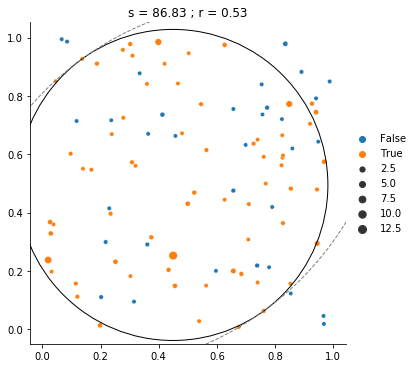

Beta : 0.045445 
Beta : 0.060593 
Beta : 0.080791 
Beta : 0.107722 
Beta : 0.143629 
Beta : 0.191505 
Beta : 0.255340 
Beta : 0.340454 
Beta : 0.453938 
Beta : 0.605251 
[0.52249488 0.46855277]


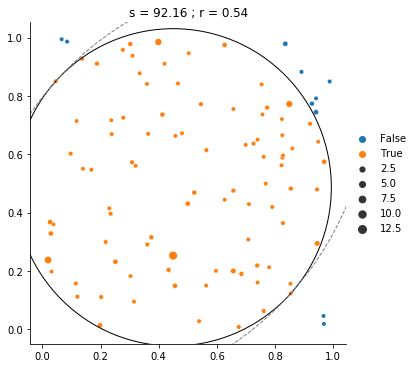

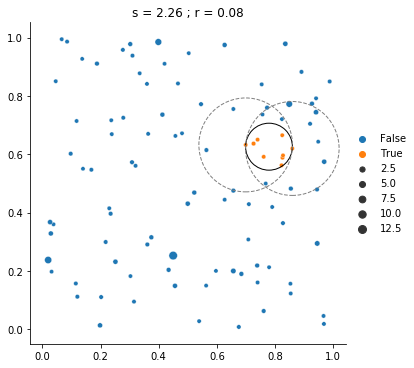

In [20]:
dataset = g2


SA = Sim_an1(0.5, dataset)
SA.heat_cool_cycles(iterations, cycles)
SA.S.plot()
plt.plot(range(iterations*cycles+1),SA.card_list)
plt.savefig("c1_g2.png")
plt.close()
plt.plot(range(iterations*cycles+1),SA.objectives)
plt.savefig("o1_g2.png")
plt.close()

SA = Sim_an2(0.5, dataset,alpha =alpha)
SA.heat_cool_cycles(iterations, cycles)
SA.S.plot()
plt.plot(range(iterations*cycles+1),SA.card_list)
plt.savefig("c2_g2.png")
plt.close()
plt.plot(range(iterations*cycles+1),SA.objectives)
plt.savefig("o2_g2.png")
plt.close()


data = create_data_model(dataset)

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], [data['min_i']], [data['min_j']])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

SA = Sim_an3(0.5, dataset, alpha = alpha, order = get_routes(solution, routing, manager)[0])
SA.heat_cool_cycles(iterations, cycles)
SA.S.plot()
plt.plot(range(iterations*cycles+1),SA.card_list)
plt.savefig("c3_g2.png")
plt.close()
plt.plot(range(iterations*cycles+1),SA.objectives)
plt.savefig("o3_g2.png")
plt.close()